# Simple Ozone Non-linearity Exercise

author: Barron Henderson

acknowledgements: Mechanism and rates from Seinfeld and Pandis (ISBN: 978-0-471-72018-8)

# Overview

This exercise uses a simple volatile organic compound, nitrogen oxide, and odd oxygen mechanism (VOC-NOx-Ox) to demonstrate the non-linearity of chemistry.

Recommended Prerequisites:
  - Basic python skills
  - Recommended reading
    - Chapter 6 of Seinfeld and Pandis (ISBN: 978-0-471-72018-8), or 
    - Chapter 12 of Jacob (ISBN: 978-0-0-691-00185-2)

# Mechanism

From [Seinfeld and Pandis Pg 240](https://books.google.com/books?id=YH2K9eWsZOcC&lpg=PT220&vq=RH%20PHOx&pg=PT220#v=onepage&f=false) we extract a basic chemical mechanism with 1 primary organic oxidation (R1). Under high NOx conditions, the primary organic oxidation produces 2 peroxy radical NO oxidations (R2,R3) to produce more radicals (i.e., HO2 or OH). The produced NO2 can photolyze (R4) to reproduce NO and an odd oxygen (O3P) that is assumed to instantaneously produce ozone. Under high-NOx conditions, the ozone can be lost by oxidizing NO (R5). Finally, radicals can be removed lost by producing nitric acid (R6) or peroxides (R7,R8). Lastly, we add an artificial source of HOx (here defined as HO2 + OH) (R9).

In [1]:
mechanism = """
#EQUATIONS
{R1} RH + OH = RO2 + H2O : 26.3e-12;
{R2} RO2 + NO = NO2 + RCHO + HO2 : 7.7e-12;
{R3} HO2 + NO = NO2 + OH : 8.1e-12;
{R4} NO2 = NO + O3 : jno2 ;
{R5} O3 + NO = NO2 + O2 : 1.9e-14 ;
{R6} OH + NO2 = HNO3 : kohno2 ; 
{R7} HO2 + HO2 = H2O2 + O2 : 2.9e-12 ;
{R8} RO2 + HO2 = ROOH + O2 : 5.2e-12 ;
{R9} EMISSION = OH : PHOx;

"""

# Setting up the environment

In [2]:
setup = """
#INLINE PY_INIT
t=TSTART=6*3600
TEND=10*3600+TSTART
P = 99600.
TEMP = 298.15
DT = 60.
MONITOR_DT = 3600.
StartDate = 'datetime(2010, 7, 14)'
Latitude_Degrees = 40.
Longitude_Degrees = 0.00E+00

jno2 = .015;
kohno2 = 1.1e-11;
#ENDINLINE
#MONITOR O3; RH; NO; NO2; OH; HO2;
#INTEGRATOR odeint;
"""

# Initial Conditions

In [3]:
init = """
#INITVALUES
CFACTOR = P * Avogadro / R / TEMP * centi **3 * nano {ppb-to-molecules/cm3}
ALL_SPEC=1e-32*CFACTOR;
M=1e9
TOTALNOx=10.
RH = 200.
O2=.21*M
N2=.79*M
H2O=0.01*M
O3=30.
NO = 0.1 * TOTALNOx
NO2 = 0.9 * TOTALNOx
PHOx = .1e-3 * CFACTOR
{B = 210.; what to do about B?}
"""

# Put it All Together

In [4]:
outfile = open('mymech.kpp', 'w')
outfile.write(setup + '\n' + mechanism + '\n' + init)
outfile.close()

# Put it in a mech

In [5]:
#from pykpp.updaters import func_updater, Monitor
import pykpp
mech = pykpp.mech.Mech('mymech.kpp', incr = 3600)

Species: 13 
Reactions: 9


**PYKPP://anaconda/lib/python3.5/site-packages/pykpp-1.0rc0-py3.5.egg/pykpp/parse.py:251:UserWarning:
  Ignoring EMISSION


# Run it

Run the basic mechanism and compare the result for ozone to the expected value (

In [6]:
mech.run();
print(eval('O3/CFACTOR', None, mech.world), 'ppb')

{t:21600,O3:30,RH:2E+02,NO:1,NO2:9,OH:1E-32,HO2:1E-32}
{t:25244,O3:69,RH:1.8E+02,NO:2.9,NO2:6.8,OH:4E-05,HO2:0.0081}
{t:28860,O3:99,RH:1.7E+02,NO:2.2,NO2:7.3,OH:3.6E-05,HO2:0.0086}
{t:32471,O3:1.2E+02,RH:1.5E+02,NO:1.8,NO2:7.4,OH:3.4E-05,HO2:0.009}
{t:36074,O3:1.5E+02,RH:1.4E+02,NO:1.6,NO2:7.4,OH:3.2E-05,HO2:0.0094}
{t:39675,O3:1.7E+02,RH:1.3E+02,NO:1.4,NO2:7.4,OH:3.2E-05,HO2:0.0096}
{t:43276,O3:1.8E+02,RH:1.2E+02,NO:1.2,NO2:7.3,OH:3.1E-05,HO2:0.0098}
{t:46877,O3:2E+02,RH:1.1E+02,NO:1.1,NO2:7.2,OH:3.1E-05,HO2:0.01}
{t:50479,O3:2.2E+02,RH:1.1E+02,NO:1,NO2:7.1,OH:3.1E-05,HO2:0.01}
{t:54080,O3:2.3E+02,RH:1E+02,NO:0.95,NO2:7,OH:3.1E-05,HO2:0.01}
242.698139913 ppb


# Ozone Non-linear Chemistry

* Well established that ozone can increase or decrease in response to emission controls.
* This can be explored easily by rerunning the model
* First initialize a range of NOx and VOC initial values
* Then run the model iteratively

In [7]:
noxvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30 , 40, 50]
vocvals = [50, 60, 70, 80, 90, 100, 200, 300, 400, 500]

# Run the model iteratively

* re-open mechanism with less frequent output
* for each nox and voc value, reset the mechanism and initialize with new values
* Run the model and store the output in o3 values

In [8]:
mech = pykpp.mech.Mech('mymech.kpp', monitor_incr = None)
import numpy as np
o3vals = np.zeros((len(noxvals), len(vocvals)), dtype = 'f')
for ni, n in enumerate(noxvals):
    for vi, v in enumerate(vocvals):
        mech.resetworld()
        CFACTOR = mech.world['CFACTOR']
        mech.world['NO'] = .1 * n * CFACTOR
        mech.world['NO2'] = .9 * n * CFACTOR
        mech.world['RH'] = v * CFACTOR
        #print(eval('NO, RH', None, mech.world))
        mech.run()
        o3vals[ni, vi] = eval('O3 / CFACTOR', None, mech.world)

**PYKPP://anaconda/lib/python3.5/site-packages/pykpp-1.0rc0-py3.5.egg/pykpp/parse.py:251:UserWarning:
  Ignoring EMISSION


Species: 13 
Reactions: 9


# Make EKMA Diagram

* plot results in an isopleth format
* one simple plot
* one prettier plot

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Simple EKMA

* make a color filed contour plot
* add a colorbar labeled ozone ppb

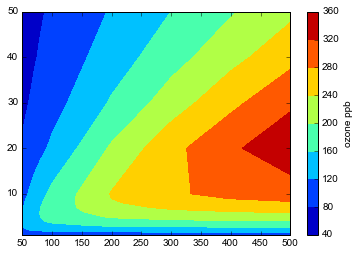

In [10]:
out = plt.contourf(vocvals, noxvals, o3vals);
plt.colorbar(out, label = 'ozone ppb');

# Prettier EKMA

* We'll use the same format as in Seinfeld and Pandis
* x and y axes will be log-scaled.
* color bar will have pretty formula

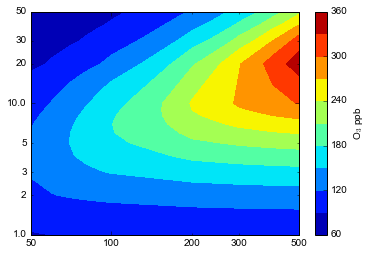

In [11]:
plt.close()
out = plt.contourf(vocvals, noxvals, plt.np.array(o3vals).reshape(len(noxvals), len(vocvals)), levels = range(60, 390, 30));
out.ax.set_xscale('log', basex = 10, subsx = [2,3,5])
out.ax.set_yscale('log', basex = 10, subsy = [2,3,5])
out.ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
out.ax.get_xaxis().set_minor_formatter(plt.ScalarFormatter())
out.ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
out.ax.get_yaxis().set_minor_formatter(plt.ScalarFormatter())
plt.colorbar(out, label = 'O$_3$ ppb');